In [1]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import h5py
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
import allel; print(allel.__version__)
%aimport allel.stats.selection

0.21.0.dev0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.3R.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.haplotypes.3R.h5" (mode r)>

In [4]:
n_variants = 200000
n_samples = 50

In [5]:
h = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, :n_samples]).to_haplotypes()
h

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [6]:
pos = callset['3R']['variants/POS'][:n_variants]
pos

array([  1252,   1262,   1271, ..., 884821, 884824, 884827], dtype=int32)

In [7]:
ac = h.count_alleles(max_allele=1)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 1)
h_seg = h.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

29163

In [8]:
%%time
score = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, include_edges=True)

CPU times: user 2.33 s, sys: 0 ns, total: 2.33 s
Wall time: 2.32 s


In [9]:
score

array([        nan,  4.04170687,  5.15924509, ...,         nan,
       -0.05084294,         nan])

In [10]:
np.count_nonzero(np.isnan(score)), np.count_nonzero(~np.isnan(score))

(327, 28836)

In [11]:
np.count_nonzero(np.isinf(score)), np.count_nonzero(~np.isinf(score))

(0, 29163)

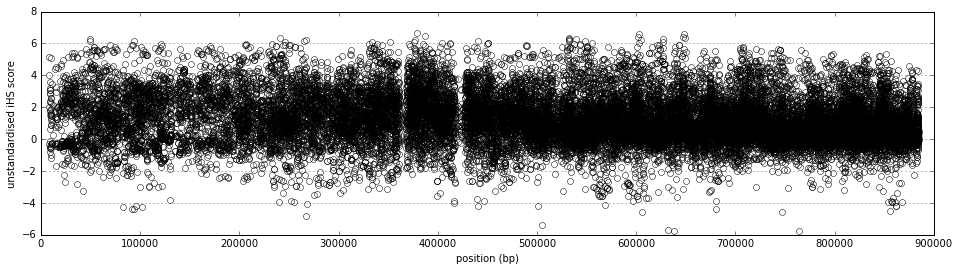

In [12]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised iHS score');

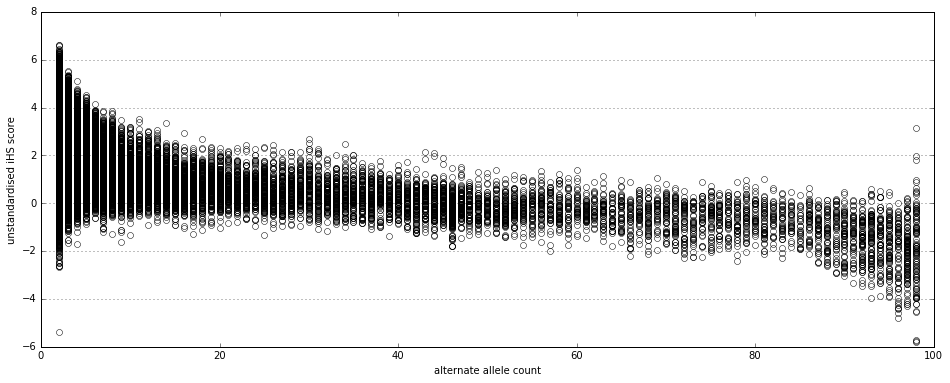

In [13]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], score, linestyle=' ', marker='o', mfc='none')
plt.xlabel('alternate allele count')
plt.ylabel('unstandardised iHS score')
plt.grid(axis='y');

In [14]:
import scipy as sp
import scipy.stats

In [15]:
bins = np.arange(h.n_haplotypes+2)
mean_ihs_by_aac, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score, statistic='mean', bins=bins)
std_ihs_by_aac, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score, statistic='std', bins=bins)

In [16]:
bins.shape

(102,)

In [17]:
mean_ihs_by_aac.shape, std_ihs_by_aac.shape

((101,), (101,))

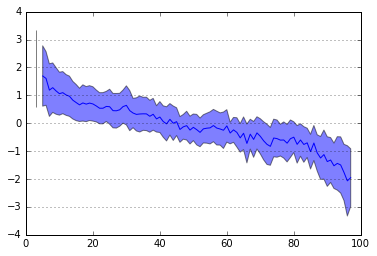

In [18]:
plt.fill_between(bins[:-1], 
                 mean_ihs_by_aac - std_ihs_by_aac, 
                 mean_ihs_by_aac + std_ihs_by_aac,
                 alpha=.5)
plt.plot(bins[:-1], mean_ihs_by_aac)
plt.grid(axis='y');

In [19]:
score_centred = np.empty_like(score)
score_normed = np.empty_like(score)

for aac in bins[:-1]:
    loc = ac_seg[:, 1] == aac
    score_centred[loc] = (score[loc] - mean_ihs_by_aac[aac]) 
    score_normed[loc] =  score_centred[loc] / std_ihs_by_aac[aac]

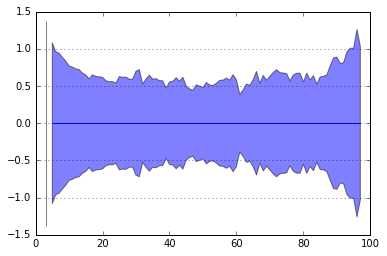

In [21]:
mean_ihs_by_aac_centred, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_centred, statistic='mean', bins=bins)
std_ihs_by_aac_centred, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_centred, statistic='std', bins=bins)
plt.fill_between(bins[:-1], 
                 mean_ihs_by_aac_centred - std_ihs_by_aac_centred, 
                 mean_ihs_by_aac_centred + std_ihs_by_aac_centred,
                 alpha=.5)
plt.plot(bins[:-1], mean_ihs_by_aac_centred)
plt.grid(axis='y');

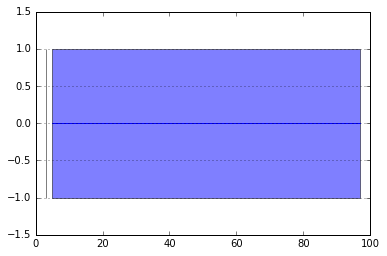

In [22]:
mean_ihs_by_aac_normed, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_normed, statistic='mean', bins=bins)
std_ihs_by_aac_normed, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_normed, statistic='std', bins=bins)
plt.fill_between(bins[:-1], 
                 mean_ihs_by_aac_normed - std_ihs_by_aac_normed, 
                 mean_ihs_by_aac_normed + std_ihs_by_aac_normed,
                 alpha=.5)
plt.plot(bins[:-1], mean_ihs_by_aac_normed)
plt.grid(axis='y');

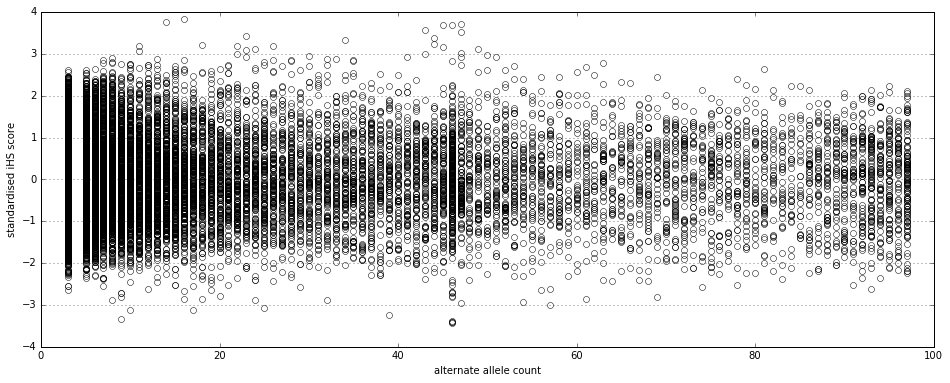

In [23]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], score_normed, linestyle=' ', marker='o', mfc='none')
plt.xlabel('alternate allele count')
plt.ylabel('standardised iHS score')
plt.grid(axis='y');

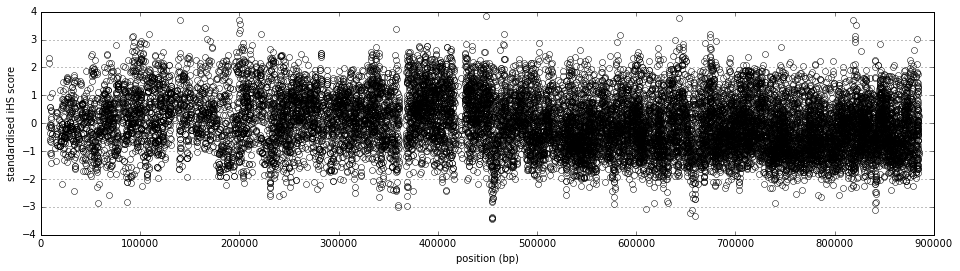

In [24]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_normed, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('standardised iHS score');

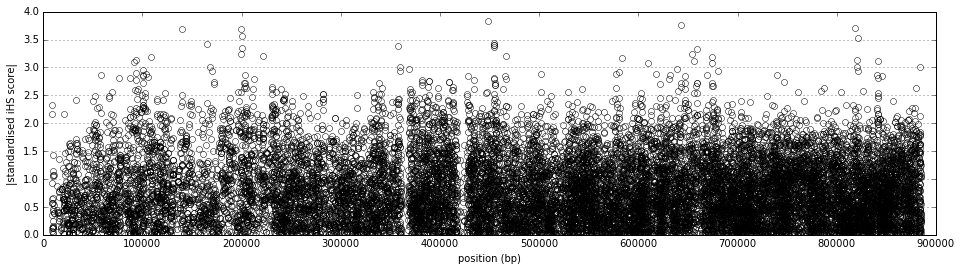

In [25]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, np.abs(score_normed), linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('|standardised iHS score|');

In [26]:
cProfile.run('allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, include_edges=True)', sort='time')

         3149724 function calls in 2.577 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   116652    1.002    0.000    1.235    0.000 stats.pyx:414(ssl2ihh)
        2    0.851    0.426    2.575    1.288 stats.pyx:554(ssl01_scan_int8)
   583278    0.161    0.000    0.161    0.000 stringsource:341(__cinit__)
   116659    0.148    0.000    0.155    0.000 {built-in method numpy.core.multiarray.array}
   233310    0.137    0.000    0.172    0.000 stringsource:985(memoryview_fromslice)
   349968    0.096    0.000    0.236    0.000 stringsource:643(memoryview_cwrapper)
   583278    0.059    0.000    0.059    0.000 stringsource:368(__dealloc__)
   116658    0.057    0.000    0.212    0.000 numeric.py:414(asarray)
   349970    0.022    0.000    0.022    0.000 stringsource:649(memoryview_check)
   233310    0.015    0.000    0.015    0.000 stringsource:962(__dealloc__)
   233308    0.014    0.000    0.014    0.000 stringsource:507(_

In [27]:
# import line_profiler

# # lprun = line_profiler.LineProfiler(allel.opt.stats.ssl01_scan_int8, allel.opt.stats.ssl2ihh)
# lprun = line_profiler.LineProfiler(allel.opt.stats.ssl01_scan_int8)
# lprun.run('allel.stats.ihs(h_seg[:1000], pos_seg[:1000], min_ehh=0, include_edges=True)')
# lprun.print_stats()